In [1]:
using DrWatson

In [2]:
@quickactivate "RxInferThesisExperiments"

In [3]:
using RxInferThesisExperiments, Turing, StaticArrays, Plots, PGFPlotsX, LaTeXStrings
using LinearAlgebra, StableRNGs, Random, BenchmarkTools, ColorSchemes, Dates, ProgressMeter

import Distributions

In [4]:
# For the thesis I use the `pgfplotsx` backend of the `Plots`, since it generates high-quiality plots
# But it is reallyyy slow, if some wants to generate plots faster uncoment the `gr()` line
pgfplotsx()

# Use fast plotting backend
# gr()

Plots.PGFPlotsXBackend()

In [5]:
const environment = HGFEnvironment()

HGFEnvironment()

In [18]:
# Include the model specification
include(srcdir("models", "turing", "hgf.jl"));

[ Info: [Turing]: progress logging is disabled globally
[ Info: [AdvancedVI]: global PROGRESS is set as false


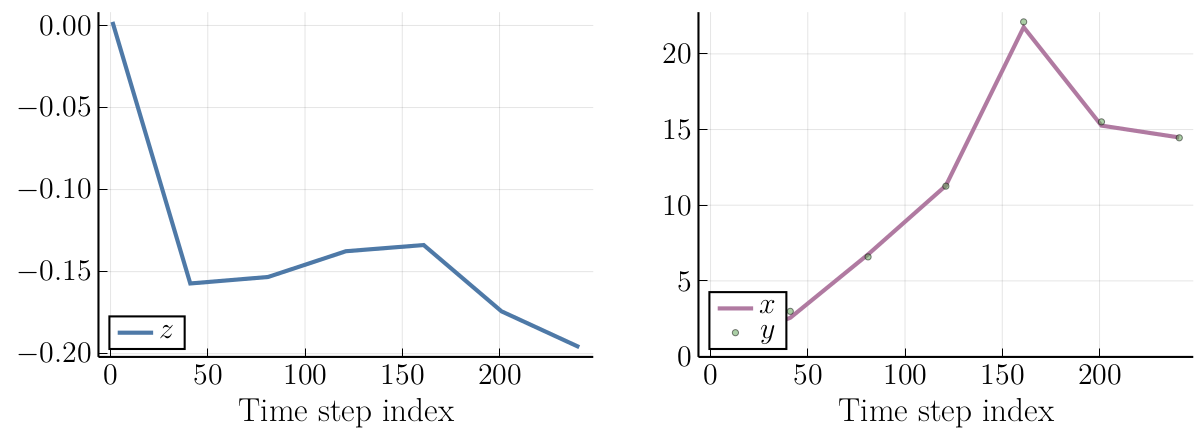

In [13]:
T = 250
seed = 12345
rng = StableRNG(seed)

zstates, xstates, observations = rand(rng, environment, T);

# `plotting` range
prange = max((lastindex(observations) - 5000), firstindex(observations)):40:lastindex(observations)
colors = ColorSchemes.tableau_10

# Some default settings for plotting
pfontsettings = (
    titlefontsize=18,
    guidefontsize=16,
    tickfontsize=14,
    legendfontsize=14,
    legend = :bottomleft,
    size = (400, 300)
)

p1 = plot(xlabel = "Time step index", ylabel = ""; pfontsettings...)
p1 = plot!(prange, zstates[prange], color = colors[1], linewidth = 2, label = L"z")

p2 = plot(xlabel = "Time step index", ylabel = ""; pfontsettings...)
p2 = plot!(p2, prange, xstates[prange], color = colors[7], linewidth = 2, label = L"x")
p2 = scatter!(p2, prange, observations[prange], color = colors[5], ms = 2, alpha = 0.5, msw = 0, label = L"y")

plot(p1, p2, layout = @layout([ a b ]), size = (800, 300))

In [14]:
# Turing need to recreate the model every time....
model = (observation, zt_min_prior, xt_min_prior, z_std_prior, y_std_prior) -> begin 
    HGF(observation, zt_min_prior, xt_min_prior, z_std_prior, y_std_prior, environment.kappa, environment.omega)
end
results = run_inference(model, observations; nsamples = 100, method = NUTS(),);

Progress: 100%|█████████████████████████████████████████| Time: 0:04:28


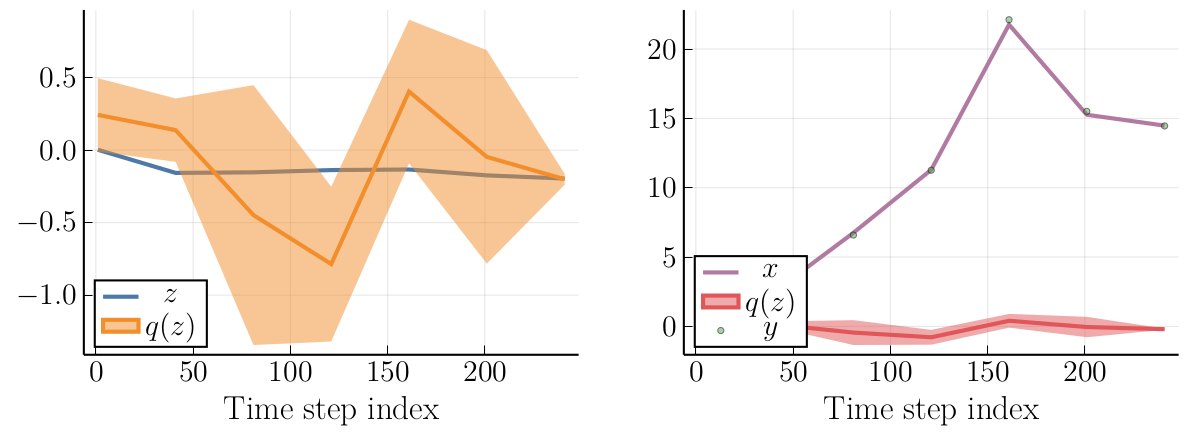

In [19]:
estimated = extract_posteriors(T, results)

emz = Distributions.mean.(estimated[:z])
evz = Distributions.std.(estimated[:z])

emx = Distributions.mean.(estimated[:x])
evx = Distributions.std.(estimated[:x])

p1 = plot(xlabel = "Time step index", ylabel = ""; pfontsettings...)
p1 = plot!(p1, prange, zstates[prange], color = colors[1], linewidth = 2, label = L"z")
p1 = plot!(p1, prange, emz[prange], ribbon = evz[prange], color = colors[2], linewidth = 2, label = L"q(z)")

p2 = plot(xlabel = "Time step index", ylabel = ""; pfontsettings...)
p2 = plot!(p2, prange, xstates[prange], color = colors[7], linewidth = 2, label = L"x")
p2 = plot!(p2, prange, emx[prange], ribbon = evx[prange], color = colors[3], linewidth = 2, label = L"q(z)")
p2 = scatter!(p2, prange, observations[prange], color = colors[5], ms = 2, alpha = 0.5, msw = 0, label = L"y")

plot(p1, p2, layout = @layout([ a b ]), size = (800, 300))